In [41]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D,
    Flatten, Dense, Dropout, BatchNormalization, Input, Activation,
    add, multiply, Reshape, Lambda, Concatenate, Layer
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import (
    EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, 
    TensorBoard, LearningRateScheduler
)
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import KFold
import time
import os
from datetime import datetime
from sklearn.model_selection import train_test_split
import torch

In [42]:
timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
output_dir = f"fashion_mnist_model_{timestamp}"
checkpoint_dir = f"{output_dir}/checkpoints"
logs_dir = f"{output_dir}/logs"
os.makedirs(checkpoint_dir, exist_ok=True)
os.makedirs(logs_dir, exist_ok=True)

In [43]:
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

In [44]:
unique_labels = np.unique(y_train)
print(f"Unique labels in the dataset: {unique_labels}")

Unique labels in the dataset: [0 1 2 3 4 5 6 7 8 9]


In [45]:
label_names = [
    "T-shirt/top",    # 0
    "Trouser",        # 1
    "Pullover",       # 2
    "Dress",          # 3
    "Coat",           # 4
    "Sandal",         # 5
    "Shirt",          # 6
    "Sneaker",        # 7
    "Bag",            # 8
    "Ankle boot"      # 9
]
for i, name in enumerate(label_names):
    print(f"{i}: {name}")

0: T-shirt/top
1: Trouser
2: Pullover
3: Dress
4: Coat
5: Sandal
6: Shirt
7: Sneaker
8: Bag
9: Ankle boot


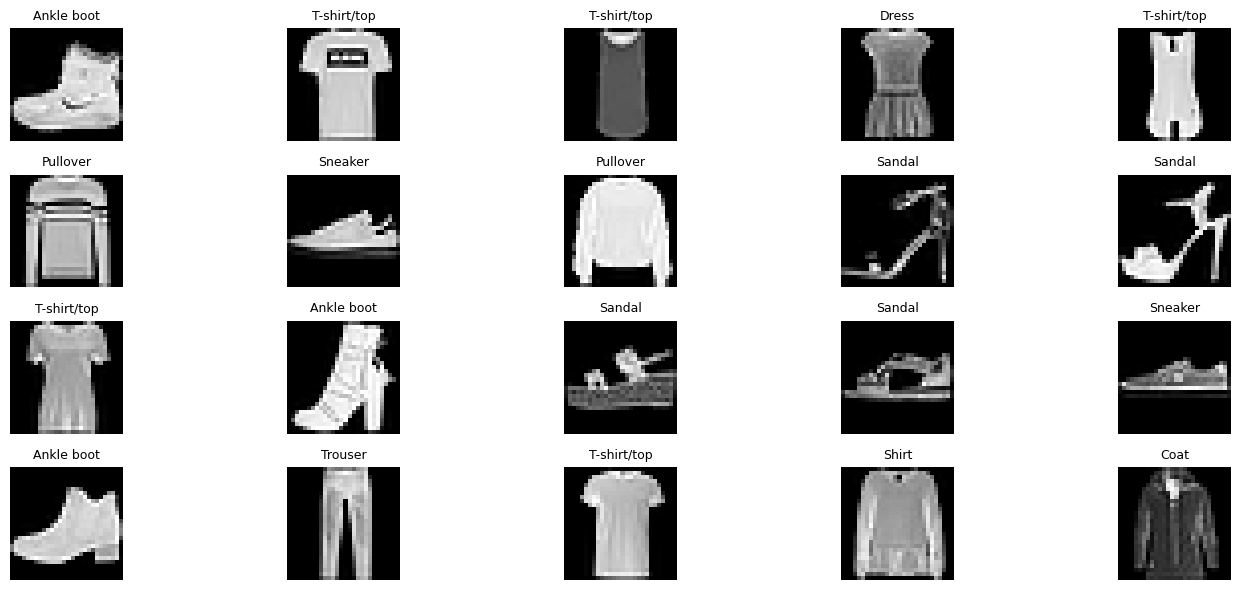

In [46]:
plt.figure(figsize=(15, 6))
for i in range(20):
    plt.subplot(4, 5, i + 1)
    plt.imshow(X_train[i], cmap='gray')
    plt.title(label_names[y_train[i]], fontsize=9)
    plt.axis('off')
plt.tight_layout()
plt.show()

In [47]:
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32') / 255.0
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1).astype('float32') / 255.0

In [48]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [49]:
y_train = to_categorical(y_train, 10)
y_val = to_categorical(y_val, 10)
y_test = to_categorical(y_test, 10)

In [50]:
class_names = ['Áo thun / Áo ngắn tay', 'Quần dài', 'Áo len chui đầu',
               'Váy liền thân', 'Áo khoác', 'Dép quai', 'Áo sơ mi',
               'Giày thể thao', 'Túi xách', 'Bốt cổ ngắn']

In [51]:
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=False,
    fill_mode='nearest'
)
datagen.fit(X_train)

In [52]:
def residual_block(x, filters, kernel_size=3, stride=1, use_bias=True, name=None):
    shortcut = x
    
    #conv1
    x = Conv2D(
        filters,
        kernel_size=kernel_size,
        strides=stride,
        padding = 'same',
        use_bias=use_bias,
        kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4),
        name = f'{name}_conv1' if name else None
    ) (x)
    
    x = BatchNormalization(name = f'{name}_bn1' if name else None) (x)
    x = Activation('relu', name = f'{name}_act1' if name else None) (x)
    
    #conv2
    x = Conv2D(
        filters,
        kernel_size=kernel_size,
        strides=1,
        padding = 'same',
        use_bias=use_bias,
        kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4),
        name = f'{name}_conv2' if name else None
    ) (x)
    
    x = BatchNormalization(name = f'{name}_bn2' if name else None) (x)
    
    input_channels = shortcut.shape[-1]
    if stride > 1 or input_channels != filters:
        shortcut = Conv2D(
            filters,
            kernel_size=1,
            strides=stride,
            padding='same',
            use_bias=use_bias,
            kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4),
            name = f'{name}_shortcut_conv' if name else None
        ) (shortcut)
        
        shortcut = BatchNormalization(name = f'{name}_shortcut_bn' if name else None) (shortcut)
        
        #Cộng nhánh chính với shortcut
    x = add([x, shortcut], name = f'{name}_add' if name else None)
    x = Activation('relu', name = f'{name}_out' if name else None) (x)
    
    return x    

In [53]:
def squeeze_excite_block(input_tensor, ratio=16):
    init = input_tensor
    channel_axis = -1
    filters = input_tensor.shape[channel_axis]
    se_shape = (1, 1, filters)
    
    #Nén
    se = GlobalAveragePooling2D()(init)
    se = Reshape(se_shape)(se)
    
    #Học trọng số của các channels
    se = Dense(filters // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)
    
    #Nhân lại với đầu vào gốc
    x = multiply([init, se])
    return x

In [54]:
class ChannelAttention(Layer):
    def __init__(self, ratio=8, **kwargs):
        super(ChannelAttention, self).__init__(**kwargs)
        self.ratio = ratio
        
    def build(self, input_shape):
        channel = input_shape[-1]
        
        self.shared_layer_one = Dense(
            channel // self.ratio,
            activation='relu',
            kernel_initializer='he_normal',
            use_bias=True,
            bias_initializer='zeros'
        )
        self.shared_layer_two = Dense(
            channel,
            kernel_initializer='he_normal',
            use_bias=True,
            bias_initializer='zeros'
        )
        
        super(ChannelAttention, self).build(input_shape)
        
    def call(self, inputs):
        avg_pool = GlobalAveragePooling2D()(inputs)
        avg_pool = Reshape((1, 1, inputs.shape[-1]))(avg_pool)
        avg_pool = self.shared_layer_one(avg_pool)
        avg_pool = self.shared_layer_two(avg_pool)
        
        max_pool = Lambda(lambda x: tf.reduce_max(x, axis=[1,2], keepdims=True))(inputs)
        max_pool = self.shared_layer_one(max_pool)
        max_pool = self.shared_layer_two(max_pool)
        
        attention = add([avg_pool, max_pool])
        attention = Activation('sigmoid')(attention)
        
        return multiply([inputs, attention])
    
    def compute_output_shape(self, input_shape):
        return input_shape

In [55]:
class SpatialAttention(Layer):
    def __init__(self, kernel_size=7, **kwargs):
        super(SpatialAttention, self).__init__(**kwargs)
        self.kernel_size = kernel_size
        
    def build(self, input_shape):
        self.conv = Conv2D(
            filters=1,
            kernel_size=self.kernel_size,
            strides=1,
            padding='same',
            activation='sigmoid',
            kernel_initializer='he_normal',
            use_bias=False,
        )
        super(SpatialAttention, self).build(input_shape)
        
    def call(self, inputs):
        avg_pool = Lambda(lambda x: tf.reduce_mean(x, axis=-1, keepdims=True))(inputs)
        
        max_pool = Lambda(lambda x: tf.reduce_max(x, axis=-1, keepdims=True))(inputs)

        concat = Concatenate()([avg_pool, max_pool])
        spatial_attention = self.conv(concat)
        
        return multiply([inputs, spatial_attention])
    
    def compute_output_shape(self, input_shape):
        return input_shape

In [56]:
def cbam_module(input_tensor):
    x = ChannelAttention()(input_tensor)
    x = SpatialAttention()(x)
    return x

In [57]:
def lr_schedule(epoch):
    lr = 1e-3
    if epoch > 30:
        lr *= 0.1
    if epoch > 60:
        lr *= 0.1
    return lr

In [58]:
def build_advanced_model(input_shape=(28, 28, 1), num_classes=10):
    inputs = Input(shape=input_shape)
    
    #Block 1
    x = Conv2D(64, kernel_size=3, strides=1, padding='same', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4))(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    #Thêm residual_block
    x = residual_block(x, 64, name='res1_1')
    x = residual_block(x, 64, name='res1_2')
    x = cbam_module(x)
    
    #Block 2
    x = residual_block(x, 128, stride=2, name='res2_1')
    x = residual_block(x, 128, name='res2_2')
    x = squeeze_excite_block(x)
    
    #Block 3
    x = residual_block(x, 256, stride=2, name='res3_1')
    x = residual_block(x, 256, name='res3_2')
    x = cbam_module(x)
    
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu', kernel_regularizer=l1_l2(l1=1e-5,l2=1e-4))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    
    outputs = Dense(num_classes, activation='softmax')(x)    
    
    
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [59]:
model = build_advanced_model()
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 28, 28,    │        640 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_11       │ (None, 28, 28,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res1_1_conv1        │ (None, 28, 28,    │     36,928 │ activation_11[0]… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res1_1_bn1          │ (None, 28, 28,    │        256 │ res1_1_conv1[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res1_1_act1         │ (None, 28, 28,    │          0 │ res1_1_bn1[0][0]  │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res1_1_conv2        │ (None, 28, 28,    │     36,928 │ res1_1_act1[0][0] │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res1_1_bn2          │ (None, 28, 28,    │        256 │ res1_1_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res1_1_add (Add)    │ (None, 28, 28,    │          0 │ res1_1_bn2[0][0], │
│                     │ 64)               │            │ activation_11[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res1_1_out          │ (None, 28, 28,    │          0 │ res1_1_add[0][0]  │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res1_2_conv1        │ (None, 28, 28,    │     36,928 │ res1_1_out[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res1_2_bn1          │ (None, 28, 28,    │        256 │ res1_2_conv1[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res1_2_act1         │ (None, 28, 28,    │          0 │ res1_2_bn1[0][0]  │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res1_2_conv2        │ (None, 28, 28,    │     36,928 │ res1_2_act1[0][0] │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res1_2_bn2          │ (None, 28, 28,    │        256 │ res1_2_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res1_2_add (Add)    │ (None, 28, 28,    │          0 │ res1_2_bn2[0][0]

 Total params: 2,921,482 (11.14 MB)

 Trainable params: 2,915,978 (11.12 MB)

 Non-trainable params: 5,504 (21.50 KB)

In [60]:
optimizer = Adam(learning_rate=1e-3)
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=3, name='top_3_accuracy'), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

In [61]:
callbacks = [
    ModelCheckpoint(
        filepath = os.path.join('checkpoint_dir', 'model-{epoch:02d}-{val_accuracy:.4f}.h5'),
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    ),
    EarlyStopping(
        monitor='val_loss',
        patience=15,
        verbose=1,
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    ),
    TensorBoard(
        log_dir=logs_dir,
        histogram_freq=1,
        write_graph=True,
        write_images=True,
        update_freq='epoch',
        profile_batch=0,
    ),
    LearningRateScheduler(lr_schedule)
]

In [62]:
batch_size = 128
epochs = 100

In [63]:
star_time = time.time()
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=batch_size),
    steps_per_epoch=len(X_train) // batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    verbose=1
)

Epoch 1/100


c:\DE\quan_ly\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


421/421 ━━━━━━━━━━━━━━━━━━━━ 0s 708ms/step - accuracy: 0.5862 - loss: 2.0512 - precision_1: 0.7427 - recall_1: 0.4615 - top_3_accuracy: 0.8447
Epoch 1: val_accuracy improved from -inf to 0.13617, saving model to checkpoint_dir\model-01-0.1362.h5


421/421 ━━━━━━━━━━━━━━━━━━━━ 319s 736ms/step - accuracy: 0.5865 - loss: 2.0503 - precision_1: 0.7428 - recall_1: 0.4619 - top_3_accuracy: 0.8449 - val_accuracy: 0.1362 - val_loss: 3.4118 - val_precision_1: 0.3041 - val_recall_1: 0.0618 - val_top_3_accuracy: 0.3293 - learning_rate: 0.0010
Epoch 2/100
  1/421 ━━━━━━━━━━━━━━━━━━━━ 5:09 736ms/step - accuracy: 0.7578 - loss: 1.3047 - precision_1: 0.8148 - recall_1: 0.6875 - top_3_accuracy: 0.9766

c:\DE\quan_ly\venv\Lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy improved from 0.13617 to 0.14283, saving model to checkpoint_dir\model-02-0.1428.h5


421/421 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.7578 - loss: 1.3047 - precision_1: 0.8148 - recall_1: 0.6875 - top_3_accuracy: 0.9766 - val_accuracy: 0.1428 - val_loss: 3.3917 - val_precision_1: 0.3178 - val_recall_1: 0.0558 - val_top_3_accuracy: 0.3293 - learning_rate: 0.0010
Epoch 3/100
421/421 ━━━━━━━━━━━━━━━━━━━━ 0s 767ms/step - accuracy: 0.7994 - loss: 1.2202 - precision_1: 0.8587 - recall_1: 0.7434 - top_3_accuracy: 0.9750
Epoch 3: val_accuracy improved from 0.14283 to 0.78567, saving model to checkpoint_dir\model-03-0.7857.h5


421/421 ━━━━━━━━━━━━━━━━━━━━ 334s 793ms/step - accuracy: 0.7994 - loss: 1.2201 - precision_1: 0.8587 - recall_1: 0.7434 - top_3_accuracy: 0.9750 - val_accuracy: 0.7857 - val_loss: 1.1125 - val_precision_1: 0.8242 - val_recall_1: 0.7457 - val_top_3_accuracy: 0.9823 - learning_rate: 0.0010
Epoch 4/100
  1/421 ━━━━━━━━━━━━━━━━━━━━ 5:20 763ms/step - accuracy: 0.8281 - loss: 1.0624 - precision_1: 0.8621 - recall_1: 0.7812 - top_3_accuracy: 0.9922
Epoch 4: val_accuracy did not improve from 0.78567
421/421 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.8281 - loss: 1.0624 - precision_1: 0.8621 - recall_1: 0.7812 - top_3_accuracy: 0.9922 - val_accuracy: 0.7772 - val_loss: 1.1189 - val_precision_1: 0.8172 - val_recall_1: 0.7420 - val_top_3_accuracy: 0.9830 - learning_rate: 0.0010
Epoch 5/100
421/421 ━━━━━━━━━━━━━━━━━━━━ 0s 753ms/step - accuracy: 0.8423 - loss: 0.9681 - precision_1: 0.8815 - recall_1: 0.8053 - top_3_accuracy: 0.9821
Epoch 5: val_accuracy improved from 0.78567 to 0.87067, savin

421/421 ━━━━━━━━━━━━━━━━━━━━ 328s 779ms/step - accuracy: 0.8423 - loss: 0.9680 - precision_1: 0.8815 - recall_1: 0.8053 - top_3_accuracy: 0.9821 - val_accuracy: 0.8707 - val_loss: 0.8034 - val_precision_1: 0.9010 - val_recall_1: 0.8453 - val_top_3_accuracy: 0.9875 - learning_rate: 0.0010
Epoch 6/100
  1/421 ━━━━━━━━━━━━━━━━━━━━ 5:12 745ms/step - accuracy: 0.8359 - loss: 0.8548 - precision_1: 0.8571 - recall_1: 0.7969 - top_3_accuracy: 0.9844
Epoch 6: val_accuracy improved from 0.87067 to 0.87700, saving model to checkpoint_dir\model-06-0.8770.h5


421/421 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.8359 - loss: 0.8548 - precision_1: 0.8571 - recall_1: 0.7969 - top_3_accuracy: 0.9844 - val_accuracy: 0.8770 - val_loss: 0.7943 - val_precision_1: 0.9095 - val_recall_1: 0.8497 - val_top_3_accuracy: 0.9877 - learning_rate: 0.0010
Epoch 7/100
421/421 ━━━━━━━━━━━━━━━━━━━━ 0s 748ms/step - accuracy: 0.8530 - loss: 0.8425 - precision_1: 0.8857 - recall_1: 0.8214 - top_3_accuracy: 0.9841
Epoch 7: val_accuracy improved from 0.87700 to 0.88417, saving model to checkpoint_dir\model-07-0.8842.h5


421/421 ━━━━━━━━━━━━━━━━━━━━ 325s 773ms/step - accuracy: 0.8530 - loss: 0.8424 - precision_1: 0.8857 - recall_1: 0.8214 - top_3_accuracy: 0.9842 - val_accuracy: 0.8842 - val_loss: 0.7231 - val_precision_1: 0.8995 - val_recall_1: 0.8682 - val_top_3_accuracy: 0.9915 - learning_rate: 0.0010
Epoch 8/100
  1/421 ━━━━━━━━━━━━━━━━━━━━ 5:18 758ms/step - accuracy: 0.8906 - loss: 0.6626 - precision_1: 0.9412 - recall_1: 0.8750 - top_3_accuracy: 0.9844
Epoch 8: val_accuracy did not improve from 0.88417
421/421 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - accuracy: 0.8906 - loss: 0.6626 - precision_1: 0.9412 - recall_1: 0.8750 - top_3_accuracy: 0.9844 - val_accuracy: 0.8797 - val_loss: 0.7274 - val_precision_1: 0.8997 - val_recall_1: 0.8640 - val_top_3_accuracy: 0.9898 - learning_rate: 0.0010
Epoch 9/100
421/421 ━━━━━━━━━━━━━━━━━━━━ 0s 772ms/step - accuracy: 0.8611 - loss: 0.7701 - precision_1: 0.8917 - recall_1: 0.8324 - top_3_accuracy: 0.9852
Epoch 9: val_accuracy did not improve from 0.88417
421/421 ━━

421/421 ━━━━━━━━━━━━━━━━━━━━ 329s 782ms/step - accuracy: 0.8882 - loss: 0.6111 - precision_1: 0.9111 - recall_1: 0.8671 - top_3_accuracy: 0.9883 - val_accuracy: 0.8975 - val_loss: 0.5632 - val_precision_1: 0.9159 - val_recall_1: 0.8838 - val_top_3_accuracy: 0.9910 - learning_rate: 0.0010
Epoch 22/100
  1/421 ━━━━━━━━━━━━━━━━━━━━ 5:13 746ms/step - accuracy: 0.8672 - loss: 0.5993 - precision_1: 0.8926 - recall_1: 0.8438 - top_3_accuracy: 1.0000
Epoch 22: val_accuracy improved from 0.89750 to 0.89883, saving model to checkpoint_dir\model-22-0.8988.h5


421/421 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.8672 - loss: 0.5993 - precision_1: 0.8926 - recall_1: 0.8438 - top_3_accuracy: 1.0000 - val_accuracy: 0.8988 - val_loss: 0.5587 - val_precision_1: 0.9163 - val_recall_1: 0.8845 - val_top_3_accuracy: 0.9922 - learning_rate: 0.0010
Epoch 23/100
421/421 ━━━━━━━━━━━━━━━━━━━━ 0s 769ms/step - accuracy: 0.8883 - loss: 0.5906 - precision_1: 0.9097 - recall_1: 0.8679 - top_3_accuracy: 0.9895
Epoch 23: val_accuracy did not improve from 0.89883
421/421 ━━━━━━━━━━━━━━━━━━━━ 335s 795ms/step - accuracy: 0.8883 - loss: 0.5906 - precision_1: 0.9097 - recall_1: 0.8678 - top_3_accuracy: 0.9895 - val_accuracy: 0.8925 - val_loss: 0.5855 - val_precision_1: 0.9135 - val_recall_1: 0.8717 - val_top_3_accuracy: 0.9908 - learning_rate: 0.0010
Epoch 24/100
  1/421 ━━━━━━━━━━━━━━━━━━━━ 6:07 876ms/step - accuracy: 0.9375 - loss: 0.4884 - precision_1: 0.9440 - recall_1: 0.9219 - top_3_accuracy: 1.0000
Epoch 24: val_accuracy did not improve from 0.89883
421/42

421/421 ━━━━━━━━━━━━━━━━━━━━ 332s 789ms/step - accuracy: 0.9099 - loss: 0.4779 - precision_1: 0.9259 - recall_1: 0.8950 - top_3_accuracy: 0.9931 - val_accuracy: 0.9177 - val_loss: 0.4222 - val_precision_1: 0.9301 - val_recall_1: 0.9093 - val_top_3_accuracy: 0.9962 - learning_rate: 1.0000e-04
Epoch 34/100
  1/421 ━━━━━━━━━━━━━━━━━━━━ 5:33 794ms/step - accuracy: 0.9062 - loss: 0.5195 - precision_1: 0.9127 - recall_1: 0.8984 - top_3_accuracy: 0.9922
Epoch 34: val_accuracy improved from 0.91767 to 0.91817, saving model to checkpoint_dir\model-34-0.9182.h5


421/421 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.9062 - loss: 0.5195 - precision_1: 0.9127 - recall_1: 0.8984 - top_3_accuracy: 0.9922 - val_accuracy: 0.9182 - val_loss: 0.4218 - val_precision_1: 0.9308 - val_recall_1: 0.9098 - val_top_3_accuracy: 0.9963 - learning_rate: 1.0000e-04
Epoch 35/100
421/421 ━━━━━━━━━━━━━━━━━━━━ 0s 761ms/step - accuracy: 0.9210 - loss: 0.4273 - precision_1: 0.9328 - recall_1: 0.9089 - top_3_accuracy: 0.9940
Epoch 35: val_accuracy did not improve from 0.91817
421/421 ━━━━━━━━━━━━━━━━━━━━ 331s 786ms/step - accuracy: 0.9210 - loss: 0.4273 - precision_1: 0.9329 - recall_1: 0.9089 - top_3_accuracy: 0.9940 - val_accuracy: 0.9150 - val_loss: 0.4147 - val_precision_1: 0.9255 - val_recall_1: 0.9072 - val_top_3_accuracy: 0.9965 - learning_rate: 1.0000e-04
Epoch 36/100
  1/421 ━━━━━━━━━━━━━━━━━━━━ 5:15 750ms/step - accuracy: 0.8906 - loss: 0.4416 - precision_1: 0.9187 - recall_1: 0.8828 - top_3_accuracy: 0.9922
Epoch 36: val_accuracy did not improve from 0.9181

421/421 ━━━━━━━━━━━━━━━━━━━━ 326s 775ms/step - accuracy: 0.9238 - loss: 0.4032 - precision_1: 0.9366 - recall_1: 0.9136 - top_3_accuracy: 0.9949 - val_accuracy: 0.9195 - val_loss: 0.3937 - val_precision_1: 0.9323 - val_recall_1: 0.9135 - val_top_3_accuracy: 0.9967 - learning_rate: 1.0000e-04
Epoch 38/100
  1/421 ━━━━━━━━━━━━━━━━━━━━ 5:18 758ms/step - accuracy: 0.9375 - loss: 0.3261 - precision_1: 0.9444 - recall_1: 0.9297 - top_3_accuracy: 1.0000
Epoch 38: val_accuracy improved from 0.91950 to 0.92100, saving model to checkpoint_dir\model-38-0.9210.h5


421/421 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - accuracy: 0.9375 - loss: 0.3261 - precision_1: 0.9444 - recall_1: 0.9297 - top_3_accuracy: 1.0000 - val_accuracy: 0.9210 - val_loss: 0.3935 - val_precision_1: 0.9320 - val_recall_1: 0.9132 - val_top_3_accuracy: 0.9967 - learning_rate: 1.0000e-04
Epoch 39/100
421/421 ━━━━━━━━━━━━━━━━━━━━ 0s 745ms/step - accuracy: 0.9261 - loss: 0.3932 - precision_1: 0.9385 - recall_1: 0.9149 - top_3_accuracy: 0.9948
Epoch 39: val_accuracy improved from 0.92100 to 0.92583, saving model to checkpoint_dir\model-39-0.9258.h5


421/421 ━━━━━━━━━━━━━━━━━━━━ 324s 770ms/step - accuracy: 0.9261 - loss: 0.3932 - precision_1: 0.9385 - recall_1: 0.9149 - top_3_accuracy: 0.9948 - val_accuracy: 0.9258 - val_loss: 0.3796 - val_precision_1: 0.9336 - val_recall_1: 0.9180 - val_top_3_accuracy: 0.9973 - learning_rate: 1.0000e-04
Epoch 40/100
  1/421 ━━━━━━━━━━━━━━━━━━━━ 5:26 777ms/step - accuracy: 0.9688 - loss: 0.3011 - precision_1: 0.9762 - recall_1: 0.9609 - top_3_accuracy: 1.0000
Epoch 40: val_accuracy improved from 0.92583 to 0.92617, saving model to checkpoint_dir\model-40-0.9262.h5


421/421 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.9688 - loss: 0.3011 - precision_1: 0.9762 - recall_1: 0.9609 - top_3_accuracy: 1.0000 - val_accuracy: 0.9262 - val_loss: 0.3784 - val_precision_1: 0.9335 - val_recall_1: 0.9190 - val_top_3_accuracy: 0.9973 - learning_rate: 1.0000e-04
Epoch 41/100
421/421 ━━━━━━━━━━━━━━━━━━━━ 0s 720ms/step - accuracy: 0.9253 - loss: 0.3799 - precision_1: 0.9374 - recall_1: 0.9156 - top_3_accuracy: 0.9951
Epoch 41: val_accuracy improved from 0.92617 to 0.92750, saving model to checkpoint_dir\model-41-0.9275.h5


421/421 ━━━━━━━━━━━━━━━━━━━━ 311s 739ms/step - accuracy: 0.9253 - loss: 0.3799 - precision_1: 0.9374 - recall_1: 0.9156 - top_3_accuracy: 0.9951 - val_accuracy: 0.9275 - val_loss: 0.3708 - val_precision_1: 0.9365 - val_recall_1: 0.9200 - val_top_3_accuracy: 0.9962 - learning_rate: 1.0000e-04
Epoch 42/100
  1/421 ━━━━━━━━━━━━━━━━━━━━ 4:22 626ms/step - accuracy: 0.9297 - loss: 0.3340 - precision_1: 0.9516 - recall_1: 0.9219 - top_3_accuracy: 1.0000
Epoch 42: val_accuracy did not improve from 0.92750
421/421 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.9297 - loss: 0.3340 - precision_1: 0.9516 - recall_1: 0.9219 - top_3_accuracy: 1.0000 - val_accuracy: 0.9272 - val_loss: 0.3709 - val_precision_1: 0.9363 - val_recall_1: 0.9193 - val_top_3_accuracy: 0.9962 - learning_rate: 1.0000e-04
Epoch 43/100
421/421 ━━━━━━━━━━━━━━━━━━━━ 0s 635ms/step - accuracy: 0.9284 - loss: 0.3746 - precision_1: 0.9389 - recall_1: 0.9182 - top_3_accuracy: 0.9945
Epoch 43: val_accuracy did not improve from 0.92750

421/421 ━━━━━━━━━━━━━━━━━━━━ 277s 657ms/step - accuracy: 0.9299 - loss: 0.3581 - precision_1: 0.9408 - recall_1: 0.9210 - top_3_accuracy: 0.9955 - val_accuracy: 0.9295 - val_loss: 0.3565 - val_precision_1: 0.9382 - val_recall_1: 0.9228 - val_top_3_accuracy: 0.9962 - learning_rate: 1.0000e-04
Epoch 46/100
  1/421 ━━━━━━━━━━━━━━━━━━━━ 4:31 646ms/step - accuracy: 0.9297 - loss: 0.3124 - precision_1: 0.9370 - recall_1: 0.9297 - top_3_accuracy: 1.0000
Epoch 46: val_accuracy did not improve from 0.92950
421/421 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.9297 - loss: 0.3124 - precision_1: 0.9370 - recall_1: 0.9297 - top_3_accuracy: 1.0000 - val_accuracy: 0.9293 - val_loss: 0.3566 - val_precision_1: 0.9375 - val_recall_1: 0.9225 - val_top_3_accuracy: 0.9963 - learning_rate: 1.0000e-04
Epoch 47/100
421/421 ━━━━━━━━━━━━━━━━━━━━ 0s 660ms/step - accuracy: 0.9313 - loss: 0.3514 - precision_1: 0.9425 - recall_1: 0.9232 - top_3_accuracy: 0.9949
Epoch 47: val_accuracy did not improve from 0.92950

421/421 ━━━━━━━━━━━━━━━━━━━━ 275s 654ms/step - accuracy: 0.9334 - loss: 0.3428 - precision_1: 0.9428 - recall_1: 0.9256 - top_3_accuracy: 0.9955 - val_accuracy: 0.9340 - val_loss: 0.3395 - val_precision_1: 0.9395 - val_recall_1: 0.9285 - val_top_3_accuracy: 0.9970 - learning_rate: 1.0000e-04
Epoch 50/100
  1/421 ━━━━━━━━━━━━━━━━━━━━ 4:35 657ms/step - accuracy: 0.9453 - loss: 0.2801 - precision_1: 0.9597 - recall_1: 0.9297 - top_3_accuracy: 0.9922
Epoch 50: val_accuracy improved from 0.93400 to 0.93433, saving model to checkpoint_dir\model-50-0.9343.h5


421/421 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.9453 - loss: 0.2801 - precision_1: 0.9597 - recall_1: 0.9297 - top_3_accuracy: 0.9922 - val_accuracy: 0.9343 - val_loss: 0.3390 - val_precision_1: 0.9398 - val_recall_1: 0.9285 - val_top_3_accuracy: 0.9968 - learning_rate: 1.0000e-04
Epoch 51/100
421/421 ━━━━━━━━━━━━━━━━━━━━ 0s 633ms/step - accuracy: 0.9351 - loss: 0.3342 - precision_1: 0.9444 - recall_1: 0.9270 - top_3_accuracy: 0.9961
Epoch 51: val_accuracy did not improve from 0.93433
421/421 ━━━━━━━━━━━━━━━━━━━━ 275s 653ms/step - accuracy: 0.9351 - loss: 0.3343 - precision_1: 0.9444 - recall_1: 0.9270 - top_3_accuracy: 0.9961 - val_accuracy: 0.9245 - val_loss: 0.3581 - val_precision_1: 0.9334 - val_recall_1: 0.9182 - val_top_3_accuracy: 0.9975 - learning_rate: 1.0000e-04
Epoch 52/100
  1/421 ━━━━━━━━━━━━━━━━━━━━ 4:26 635ms/step - accuracy: 0.9375 - loss: 0.3135 - precision_1: 0.9449 - recall_1: 0.9375 - top_3_accuracy: 0.9844
Epoch 52: val_accuracy did not improve from 0.93433

421/421 ━━━━━━━━━━━━━━━━━━━━ 268s 636ms/step - accuracy: 0.9413 - loss: 0.2921 - precision_1: 0.9491 - recall_1: 0.9358 - top_3_accuracy: 0.9972 - val_accuracy: 0.9352 - val_loss: 0.3192 - val_precision_1: 0.9403 - val_recall_1: 0.9285 - val_top_3_accuracy: 0.9972 - learning_rate: 1.0000e-05
Epoch 74/100
  1/421 ━━━━━━━━━━━━━━━━━━━━ 4:20 620ms/step - accuracy: 0.9453 - loss: 0.2864 - precision_1: 0.9524 - recall_1: 0.9375 - top_3_accuracy: 0.9922
Epoch 74: val_accuracy did not improve from 0.93517
421/421 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.9453 - loss: 0.2864 - precision_1: 0.9524 - recall_1: 0.9375 - top_3_accuracy: 0.9922 - val_accuracy: 0.9348 - val_loss: 0.3194 - val_precision_1: 0.9401 - val_recall_1: 0.9285 - val_top_3_accuracy: 0.9972 - learning_rate: 1.0000e-05
Epoch 75/100
421/421 ━━━━━━━━━━━━━━━━━━━━ 0s 617ms/step - accuracy: 0.9413 - loss: 0.2912 - precision_1: 0.9500 - recall_1: 0.9340 - top_3_accuracy: 0.9973
Epoch 75: val_accuracy did not improve from 0.93517

421/421 ━━━━━━━━━━━━━━━━━━━━ 267s 634ms/step - accuracy: 0.9412 - loss: 0.2895 - precision_1: 0.9486 - recall_1: 0.9353 - top_3_accuracy: 0.9970 - val_accuracy: 0.9357 - val_loss: 0.3135 - val_precision_1: 0.9402 - val_recall_1: 0.9303 - val_top_3_accuracy: 0.9975 - learning_rate: 1.0000e-05
Epoch 80/100
  1/421 ━━━━━━━━━━━━━━━━━━━━ 4:26 635ms/step - accuracy: 0.9141 - loss: 0.3635 - precision_1: 0.9141 - recall_1: 0.9141 - top_3_accuracy: 1.0000
Epoch 80: val_accuracy did not improve from 0.93567
421/421 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.9141 - loss: 0.3635 - precision_1: 0.9141 - recall_1: 0.9141 - top_3_accuracy: 1.0000 - val_accuracy: 0.9357 - val_loss: 0.3135 - val_precision_1: 0.9405 - val_recall_1: 0.9302 - val_top_3_accuracy: 0.9975 - learning_rate: 1.0000e-05
Epoch 81/100
421/421 ━━━━━━━━━━━━━━━━━━━━ 0s 615ms/step - accuracy: 0.9420 - loss: 0.2887 - precision_1: 0.9494 - recall_1: 0.9363 - top_3_accuracy: 0.9970
Epoch 81: val_accuracy did not improve from 0.93567

421/421 ━━━━━━━━━━━━━━━━━━━━ 266s 632ms/step - accuracy: 0.9435 - loss: 0.2878 - precision_1: 0.9504 - recall_1: 0.9375 - top_3_accuracy: 0.9971 - val_accuracy: 0.9363 - val_loss: 0.3145 - val_precision_1: 0.9414 - val_recall_1: 0.9315 - val_top_3_accuracy: 0.9972 - learning_rate: 1.0000e-05
Epoch 84/100
  1/421 ━━━━━━━━━━━━━━━━━━━━ 4:22 626ms/step - accuracy: 0.9219 - loss: 0.2836 - precision_1: 0.9286 - recall_1: 0.9141 - top_3_accuracy: 1.0000
Epoch 84: val_accuracy did not improve from 0.93633

Epoch 84: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
421/421 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.9219 - loss: 0.2836 - precision_1: 0.9286 - recall_1: 0.9141 - top_3_accuracy: 1.0000 - val_accuracy: 0.9363 - val_loss: 0.3145 - val_precision_1: 0.9414 - val_recall_1: 0.9312 - val_top_3_accuracy: 0.9972 - learning_rate: 5.0000e-06
Epoch 85/100
421/421 ━━━━━━━━━━━━━━━━━━━━ 0s 614ms/step - accuracy: 0.9452 - loss: 0.2825 - precision_1: 0.9520 - recall_1: 0.938

421/421 ━━━━━━━━━━━━━━━━━━━━ 266s 633ms/step - accuracy: 0.9452 - loss: 0.2825 - precision_1: 0.9520 - recall_1: 0.9388 - top_3_accuracy: 0.9973 - val_accuracy: 0.9365 - val_loss: 0.3102 - val_precision_1: 0.9419 - val_recall_1: 0.9325 - val_top_3_accuracy: 0.9973 - learning_rate: 1.0000e-05
Epoch 86/100
  1/421 ━━━━━━━━━━━━━━━━━━━━ 4:28 639ms/step - accuracy: 0.9375 - loss: 0.2592 - precision_1: 0.9600 - recall_1: 0.9375 - top_3_accuracy: 0.9922
Epoch 86: val_accuracy did not improve from 0.93650
421/421 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.9375 - loss: 0.2592 - precision_1: 0.9600 - recall_1: 0.9375 - top_3_accuracy: 0.9922 - val_accuracy: 0.9365 - val_loss: 0.3102 - val_precision_1: 0.9421 - val_recall_1: 0.9323 - val_top_3_accuracy: 0.9973 - learning_rate: 1.0000e-05
Epoch 87/100
421/421 ━━━━━━━━━━━━━━━━━━━━ 0s 617ms/step - accuracy: 0.9461 - loss: 0.2793 - precision_1: 0.9539 - recall_1: 0.9403 - top_3_accuracy: 0.9974
Epoch 87: val_accuracy did not improve from 0.93650

In [64]:
training_time = time.time() - star_time
print(f"Thời gian huấn luyện: {training_time:.2f} giây")

Thời gian huấn luyện: 15253.69 giây


In [65]:
test_loss, test_acc, test_top3_acc, test_precision, test_recall = model.evaluate(X_test, y_test)
print(f'\nKết quả đánh giá trên tập test:')
print(f'- Độ chính xác: {test_acc*100:.2f}%')
print(f'- Top-3 Accuracy: {test_top3_acc*100:.2f}%')
print(f'- Precision: {test_precision:.4f}')
print(f'- Recall: {test_recall:.4f}')
print(f'- Loss: {test_loss:.4f}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 13s 43ms/step - accuracy: 0.9310 - loss: 0.3183 - precision_1: 0.9366 - recall_1: 0.9258 - top_3_accuracy: 0.9967

Kết quả đánh giá trên tập test:
- Độ chính xác: 92.96%
- Top-3 Accuracy: 99.61%
- Precision: 0.9359
- Recall: 0.9249
- Loss: 0.3224


In [66]:
final_model_path = os.path.join(output_dir, 'fashion_mnist_final_model.h5')
model.save(final_model_path)
print(f"Đã lưu mô hình cuối cùng vào '{final_model_path}'")

Đã lưu mô hình cuối cùng vào 'fashion_mnist_model_20250419-153117\fashion_mnist_final_model.h5'


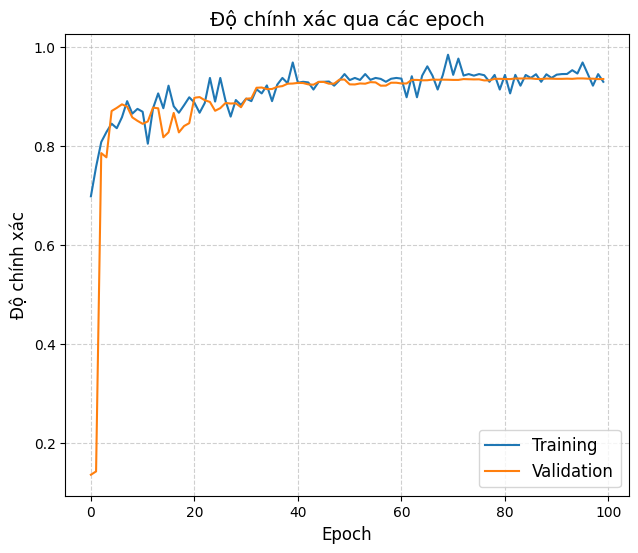

In [67]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Độ chính xác qua các epoch', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Độ chính xác', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

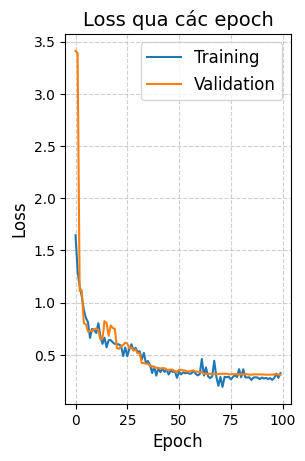

In [68]:
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Loss qua các epoch', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

In [69]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step


In [70]:
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

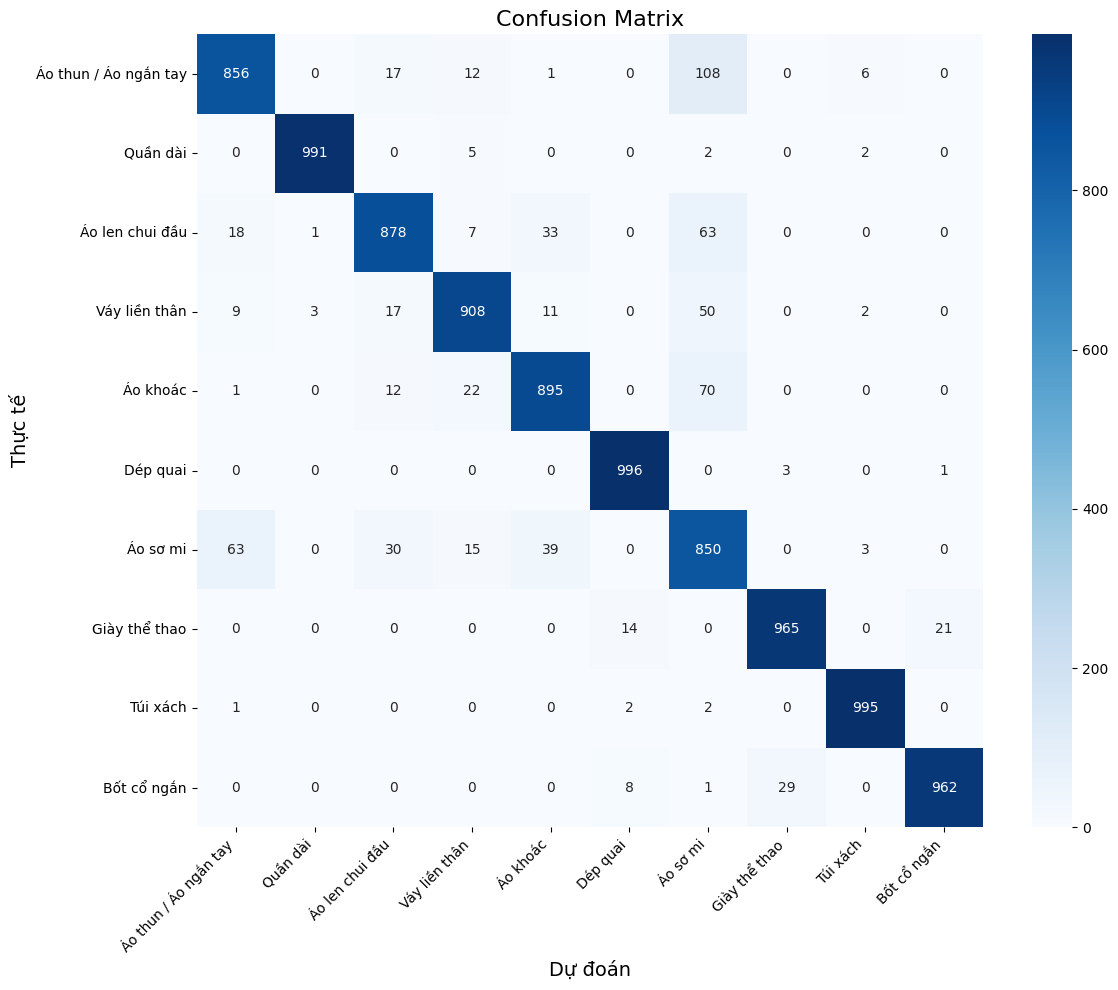

In [71]:
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Dự đoán', fontsize=14)
plt.ylabel('Thực tế', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'confusion_matrix.png'), dpi=300, bbox_inches='tight')
plt.show()

In [72]:
print("\nClassification Report:")
class_report = classification_report(y_true_classes, y_pred_classes, target_names=class_names)
print(class_report)


Classification Report:
                       precision    recall  f1-score   support

Áo thun / Áo ngắn tay       0.90      0.86      0.88      1000
             Quần dài       1.00      0.99      0.99      1000
      Áo len chui đầu       0.92      0.88      0.90      1000
        Váy liền thân       0.94      0.91      0.92      1000
             Áo khoác       0.91      0.90      0.90      1000
             Dép quai       0.98      1.00      0.99      1000
             Áo sơ mi       0.74      0.85      0.79      1000
        Giày thể thao       0.97      0.96      0.97      1000
             Túi xách       0.99      0.99      0.99      1000
          Bốt cổ ngắn       0.98      0.96      0.97      1000

             accuracy                           0.93     10000
            macro avg       0.93      0.93      0.93     10000
         weighted avg       0.93      0.93      0.93     10000



In [73]:
def plot_predictions(X, y_true, y_pred, class_names, num_samples=20):
    # Chọn ngẫu nhiên các mẫu
    indices = np.random.choice(range(len(X)), num_samples, replace=False)
    
    # Tạo lưới hình ảnh
    rows = int(np.ceil(num_samples / 5))
    fig, axes = plt.subplots(rows, 5, figsize=(15, rows * 3))
    axes = axes.flatten()
    
    for i, idx in enumerate(indices):
        if i < len(axes):
            # Hiển thị hình ảnh
            axes[i].imshow(X[idx].reshape(28, 28), cmap='gray')
            
            # Thông tin dự đoán
            true_label = np.argmax(y_true[idx])
            pred_label = np.argmax(y_pred[idx])
            confidence = np.max(y_pred[idx]) * 100
            
            # Màu sắc tiêu đề dựa trên dự đoán đúng/sai
            color = 'green' if true_label == pred_label else 'red'
            
            # Tiêu đề cho hình ảnh
            title = f"Thực tế: {class_names[true_label]}\nDự đoán: {class_names[pred_label]}\nĐộ tin cậy: {confidence:.1f}%"
            axes[i].set_title(title, color=color, fontsize=9)
            axes[i].axis('off')
    
    # Ẩn các trục thừa
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')
    
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'sample_predictions.png'), dpi=300, bbox_inches='tight')
    plt.show()

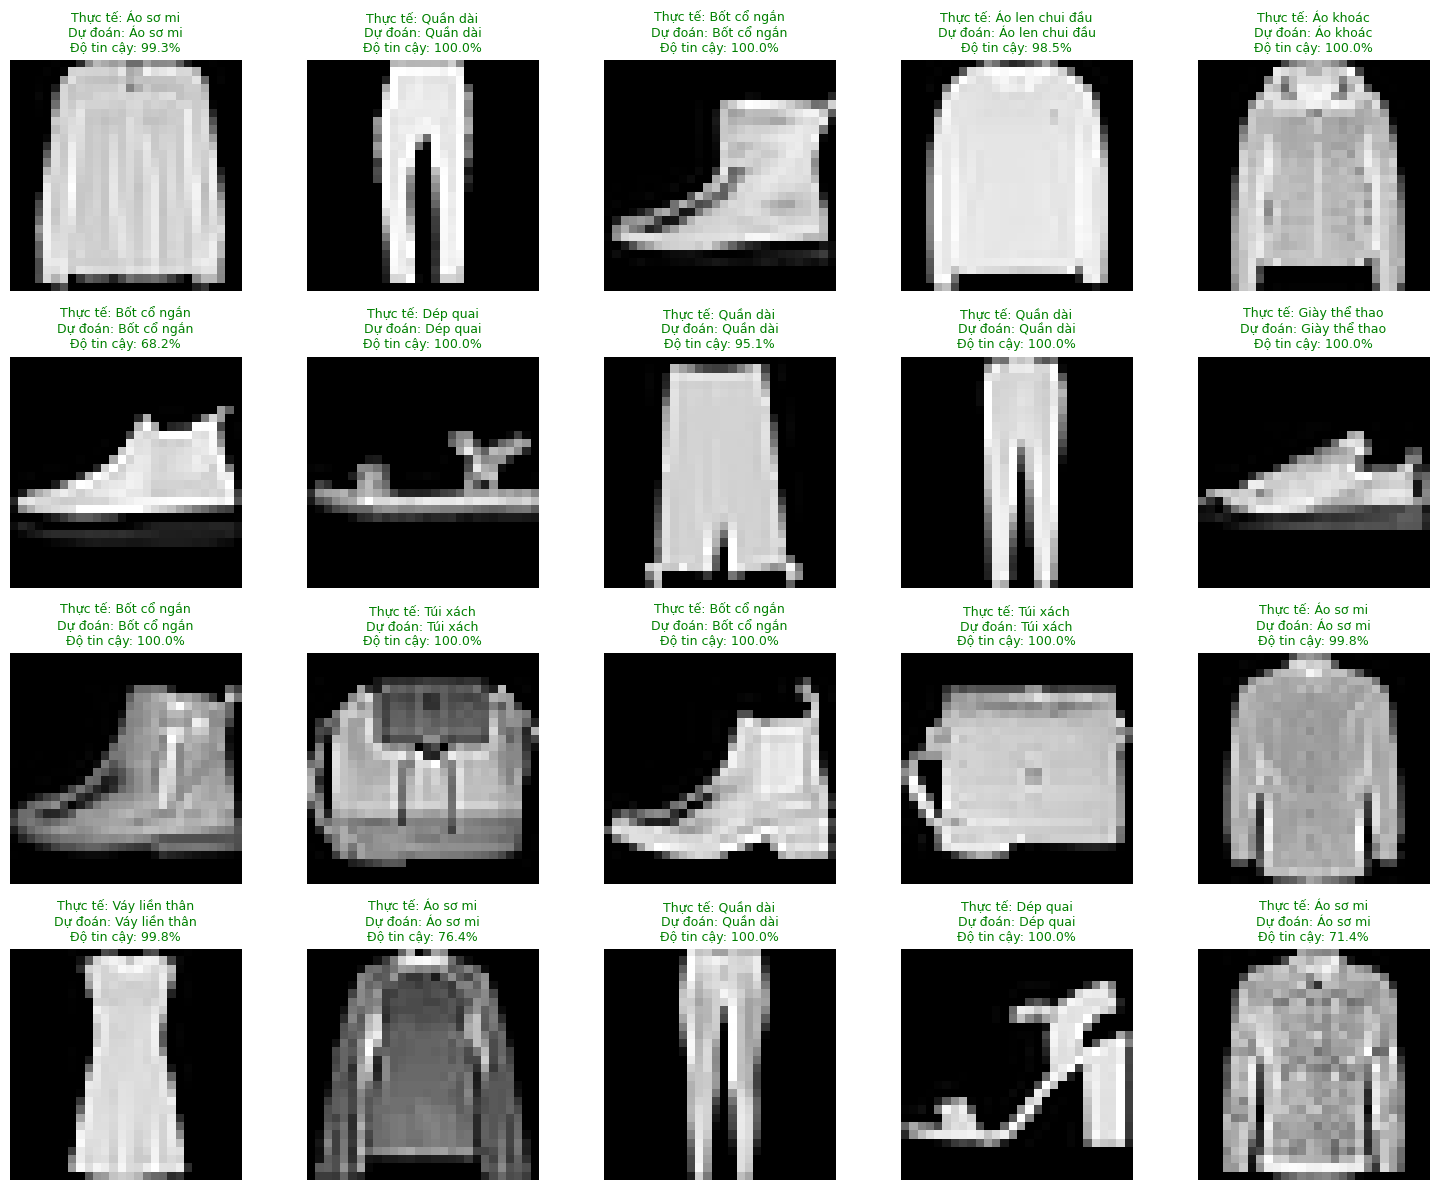

In [74]:
plot_predictions(X_test, y_test, y_pred, class_names, num_samples=20)